# Overview

This notebook is for generating TFRecord files from OCT scans, for use as input in RaSCL models. 

# Dependencies

In [1]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.image import resize
tf.get_logger().setLevel("ERROR")
tf.compat.v1.enable_eager_execution()
%matplotlib inline

2024-03-20 23:18:44.262710: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Functions

In [2]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_feature_list(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, label, idno):
    feature = {
        "image": image_feature(image),
        "label": int64_feature(label),
        "id": int64_feature(idno),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def split_data_by_group(dataframe, group, seed=1, breaks=(0.75,0.9), random=True):
    """
    Splits dataframe into subset with respect to group.

    Parameters:
    dataframe (obj) : A Pandas DataFrame object
    group (str)     : A string describing dataframe column
    seed (int)      : Seed for random function
    breaks (tup)    : Ascending set of n values < 1 to split dataframe
    
    Returns:
    obj[n+1]        : Set of n+1 dataframes as per number of breaks 
    
    """
    # Attempted to construct by built-in Pandas groupby tools, but they would not keep data segregated for this purpose.
    # This is a reliable method.
    x = dataframe[group].unique()
    if random:
        np.random.seed(seed)
        np.random.shuffle(x)
    return [dataframe.loc[dataframe[group].isin(i)] for i in np.split(x,[int(j*len(x)) for j in breaks])]

def rms(x,y):
    return math.sqrt(sum((x - y)**2)/len(x))

def rms_weighted(x,y,weights):
    return math.sqrt(sum(((x - y)*weights)**2)/len(x))

def npdivzero(numerator, denominator):
    with np.errstate(divide='ignore'):
        result = numerator / denominator
        result[:,denominator == 0] = 0
        return result
    
def get_studybatched_scans(scan_dir, data, size, margin, mask = [], labels = []):
    # Nested iterator to assemble datasets across split
    idx = data.Study.values
    files = [file for file in os.listdir(scan_dir) if '.jpeg' in file]
    if len(mask) == 0:
        mask = np.ones(len(idx), dtype=bool)
    if len(labels) == 0:
        labels = np.zeros(len(idx), dtype=np.int32)
        
    def create_example(image, label, idno, scanno):
        feature = {
            "image": int64_feature_list(image),
            "label": int64_feature(label),
            "id": int64_feature(idno),
            "scans": int64_feature(scanno)
        }
        return tf.train.Example(features=tf.train.Features(feature=feature))
    examples = {}
    for i in range(len(idx)):
        if not mask[i]:
            continue
        study = idx[i]
        f_in = []
        cidx = int(data['b-slice central'][data.Study == study].values[0])
        bmax = int(data['b-slice total'][data.Study == study].values[0])
        while cidx+margin+1 >= bmax:
            cidx -= 1
        while cidx-margin < 0:
            cidx += 1
        for f in [f'{int(study):03}{j:03d}.jpeg' for j in range(cidx-margin,cidx+margin+1)]:
            if f in files:
                # Cropping margins to fit 496x496 motif
                img = tf.io.decode_jpeg(
                    tf.io.read_file(os.path.join(scan_dir, f))
                )
                img = tf.cast(resize(img, (size, size)), tf.uint8)
                f_in.append(img)
        # Only writing studies with neighboring images to compare
        if len(f_in) > 1:
            study_idx = study == data.Study.values
            label = labels[i]  

                # Image name, can be decoded to study and slice index
            idno = int(study)
            scanno = len(f_in)
            fmerge = tf.concat(f_in + [tf.zeros((size,size,margin*2 + 1 - len(f_in)),
                                                dtype=img.dtype)],
                               axis=-1)
            example = create_example(fmerge.numpy().flatten().tolist(), label, idno, scanno)
            examples[study] = example
    return examples

def get_centralmargin_scans(scan_dir, data, size, margin, create_example=None, mask = [], labels = []):
    # Nested iterator to assemble datasets across split
    # Expects data in .png format
    idx = data.Study.values
    files = [file for file in os.listdir(scan_dir) if 'png' in file]
    if len(mask) == 0:
        mask = np.ones(len(idx), dtype=bool)
    if len(labels) == 0:
        labels = np.zeros(len(idx), dtype=np.int32)

    if create_example == None:
        def create_example(image, label, idno, scanno):
            feature = {
                "image": int64_feature_list(image),
                "label": int64_feature(label),
                "id": int64_feature(idno),
                "scan": int64_feature(scanno),
            }
            return tf.train.Example(features=tf.train.Features(feature=feature))

    examples = {}
    for i in range(len(idx)):
        if not mask[i]:
            continue
        study = idx[i]
        f_in = {}
        cidx = int(data['central scan'][data.Study == study].values[0])
        bmax = int(data['total scans'][data.Study == study].values[0])
        while cidx+margin+1 >= bmax:
            cidx -= 1
        while cidx-margin < 0:
            cidx += 1
        # Finds files based on expected format.
        for f in [f'{int(study):03}-{j:01}.png' for j in range(cidx-margin,cidx+margin+1)]:
            if f in files:
                # Cropping margins to fit size motif
                img = tf.io.decode_png(
                    tf.io.read_file(os.path.join(scan_dir, f))
                )
                img = tf.cast(resize(img, (size, size)), tf.uint8)
                f_in[int(f.split('.')[0].split('-')[1])] = img
        # Only writing studies with neighboring images to compare
        if len(f_in) > 1:
            study_idx = study == data.Study.values
            label = labels[i]  

                # Image name, can be decoded to study and slice index
            idno = int(study)
            example = [create_example(f_in[scanno].numpy().flatten().tolist(), label, idno, scanno) for scanno in f_in.keys()]
            examples[study] = example
    return examples

## Split validation by RMSE minimization of normalized targets

To stratify our data across a set of numerical and factorial features, I applied a method of minimising root mean squared error compared to ordinized subsets of the overall distribution. This was done by taking random splits generated across a range of seeds and taking the best fits (lowest RMSE).

This data splitting is done in two steps to account for both test and k-fold validation splitting. 

### Loading data

In [3]:
data = pd.read_csv('./data/study data.csv')

### Test set split

In [4]:
# Demographic targets to stratify
targets = ['LogMAR','Age','Gender','Diagnosis'] 
# How important each target is. Weighting diagnosis most heavily to ensure balanced data along the labeling axis.
target_weights = {targets[i]:[1,1,1,8][i] for i in range(len(targets))}

# Number of test seeds to try
seed_tests = 100000

# Test set breaks
breaks = [0.15,0.3,0.45]
df = data.copy()
x,m,n,w = [],{},{},[]
for target in targets:
    if df[target].dtype == 'object':
        df[target] = pd.factorize(df[target])[0]
    # Storing true mean and SD for later transformation
    m[target] = df[target].mean()
    n[target] = df[target].std()
    # Normalizing overall data to compare target columns
    # Setting diagnosis to 4:1 split for test sets to compensate for data balancing.
    if target == 'Diagnosis':
        df[target] = (df[target] - 0.8) / n[target]
    else:
        df[target] = (df[target] - m[target]) / n[target]
    # Generating structured list to create comparison matrix
    x.extend([0 for i in range(len(breaks))]+
             [1 for i in range(len(breaks))])
    w.extend([target_weights[target] for i in range(len(breaks))]+
                   [target_weights[target] for i in range(len(breaks))])
x = np.asarray(x)
w = np.asarray(w)
rmse = []
for i in range(seed_tests):
    data_split = split_data_by_group(df, group='Study', seed=i, breaks=breaks)[:3]
    y = []
    for target in targets:
        y.extend([dataset[target].mean() for dataset in data_split]+
                 [dataset[target].std() for dataset in data_split])
    rmse.append(rms_weighted(x,np.asarray(y),w))
# Generates rmse (root mean squared error) for target distribution in data
rmse = np.asarray(rmse)

test_seed = rmse.argsort()[0]
print(test_seed)

58807


### K-fold validation split

In [5]:

# Number of validation groups to split data into.
kfold=8

# Demographic targets to stratify
targets = ['LogMAR','Age','Gender','Diagnosis']
# How important each target is. Overweighting Diagnosis to ensure equivalent distributions across all kfolds.
target_weights = {targets[i]:[1,1,1,6][i] for i in range(len(targets))}

# Names and order of data splits
data_splits = [f'train{k}' for k in range(kfold)]
# Fractions to split along
breaks = [1.*k/kfold for k in range(kfold)][1:]
# Breaks for splitting test data before kfold split.
test_breaks = [0.15,0.3,0.45]
# Number of test seeds to try
seed_tests = 100000
seed_vals = []
for p in range(3):
    df = split_data_by_group(data, group='Study', seed=test_seed, breaks=test_breaks)
    df.pop(p)
    df = pd.concat(df)
    x,m,n,w = [],{},{},[]
    for target in targets:
        if df[target].dtype == 'object':
            df[target] = pd.factorize(df[target])[0]
        # Storing true mean and SD for later transformation
        m[target] = df[target].mean()
        n[target] = df[target].std()
        # Normalizing overall data to compare target columns
        df[target] = (df[target] - m[target]) / n[target]
        # Generating structured list to create comparison matrix
        x.extend([0 for i in range(len(breaks)+1)]+
                 [1 for i in range(len(breaks)+1)])
        w.extend([target_weights[target] for i in range(len(breaks)+1)]+
                       [target_weights[target] for i in range(len(breaks)+1)])
    x = np.asarray(x)
    w = np.asarray(w)
    rmse = []
    for i in range(seed_tests):
        data_split = split_data_by_group(df, group='Study', seed=i, breaks=breaks)
        y = []
        for target in targets:
            y.extend([dataset[target].mean() for dataset in data_split]+
                     [dataset[target].std() for dataset in data_split])
        rmse.append(rms_weighted(x,np.asarray(y),w))
    # Generates rmse (root mean squared error) for target distribution in data
    rmse = np.asarray(rmse)
    seed_vals.append(rmse.argsort()[0])
print(seed_vals)

[79872, 63126, 16145]


### Validation plotting

To confirm that our data has been stratified according to the above method, let's plot the distributions of our data splits from each seed.

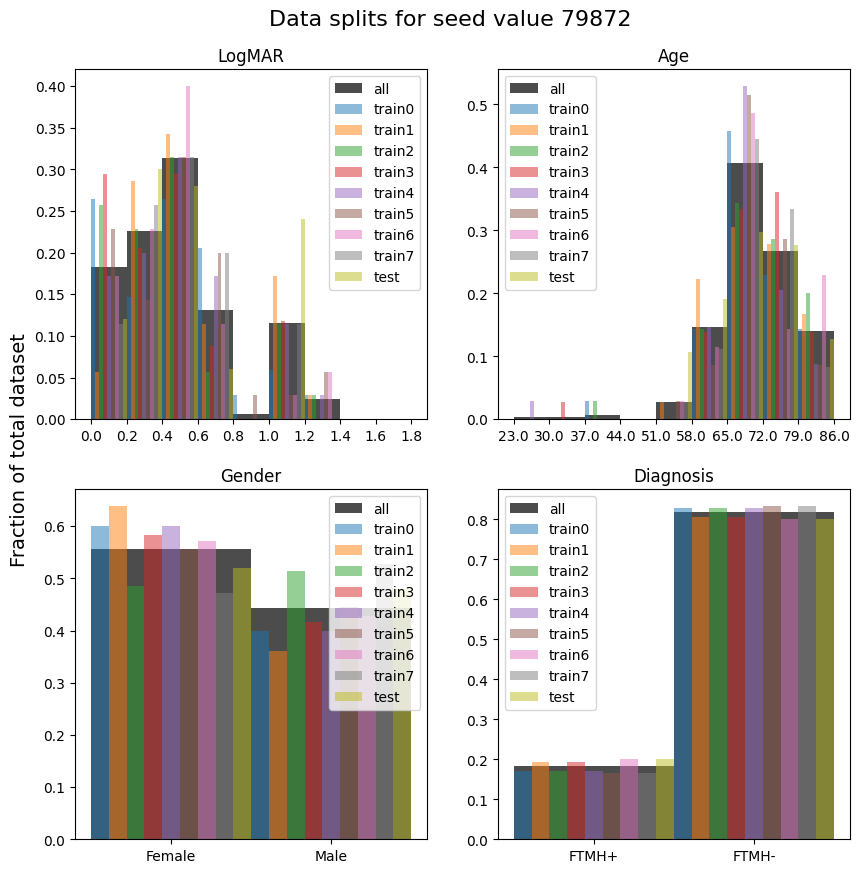

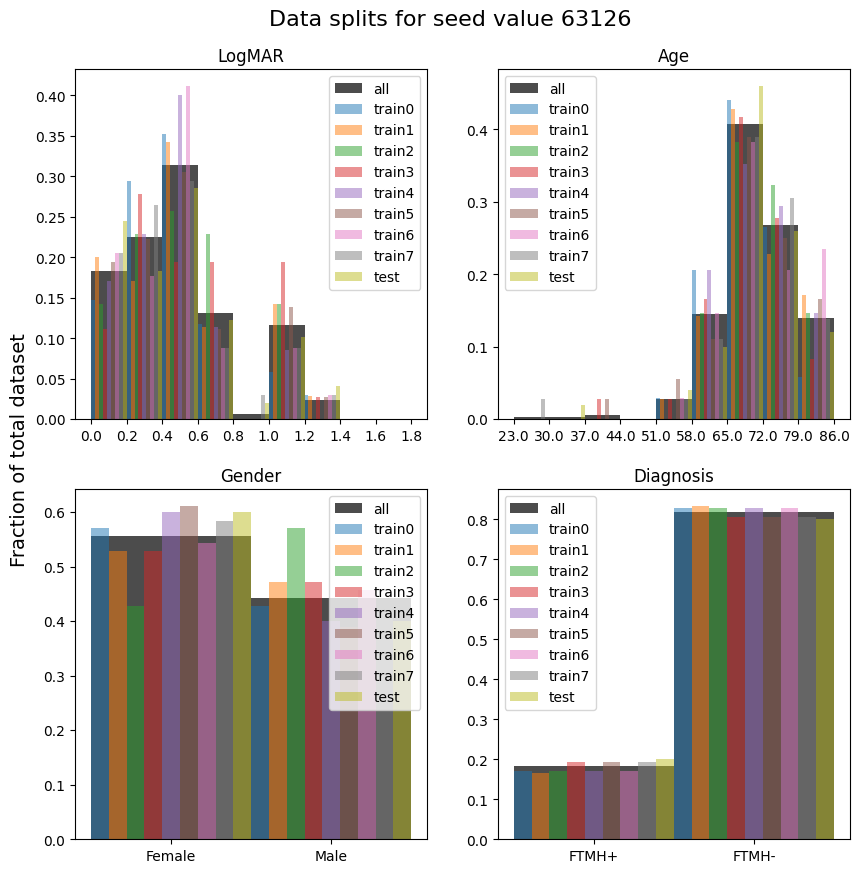

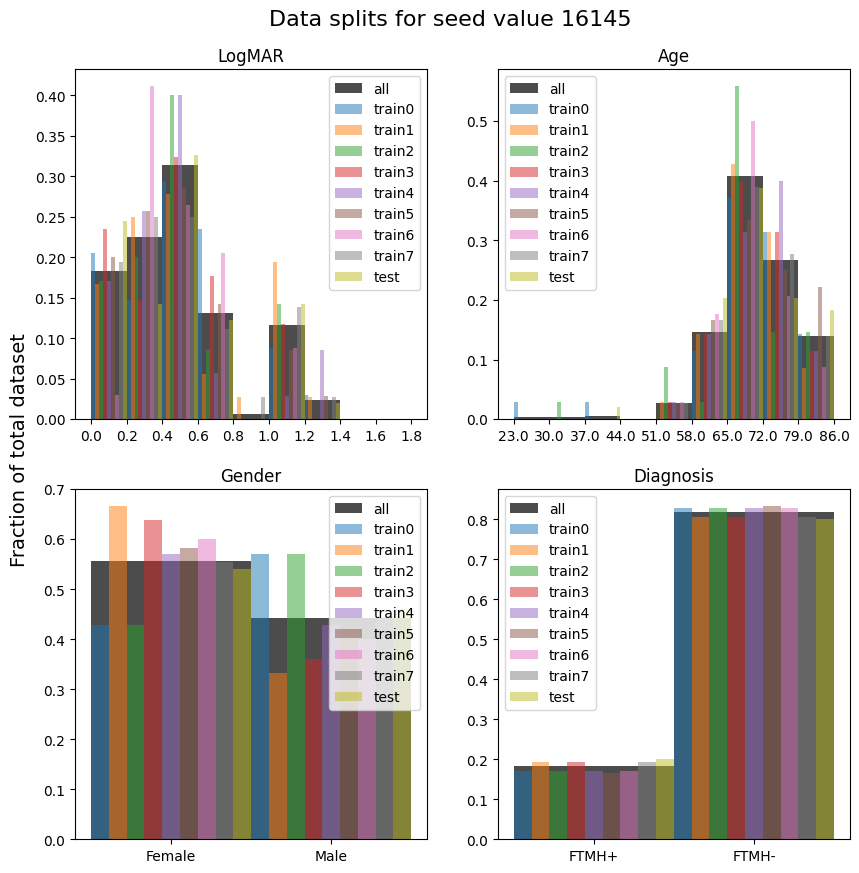

In [6]:

data_splits = [f'train{k}' for k in range(kfold)] + ['test']
for p in range(len(seed_vals)):
    seed_val = seed_vals[p]
    df = split_data_by_group(data, group='Study', seed=test_seed, breaks=test_breaks)
    test_df = df.pop(p)
    df = pd.concat(df)
    split_data = dict(zip(data_splits,
                          split_data_by_group(df, group='Study', seed=seed_val, breaks=breaks)+[test_df]))

    cols = 2
    rows = math.ceil(len(targets) / cols)
    fig = plt.figure(figsize=(5*cols,5*rows))
    fig.suptitle(f'Data splits for seed value {seed_val}',fontsize=16,y=0.94)
    fig.supylabel('Fraction of total dataset',fontsize=14,x=0.06)
    for i in range(len(targets)):
        target = targets[i]
        nl, binsl, dl = [],[],[]
        fig.add_subplot(rows,cols,i+1)
        if len(data[target].unique()) > 10:
            bins = np.arange(data[target].min(),data[target].max(),
                             (data[target].max()-data[target].min())/10)
            increment = (bins[1] - bins[0]) / (len(split_data))
        else:
            bins = np.arange(len(data[target].unique())+1)
            increment = 1/(len(split_data))
        if data[target].dtype == 'object':
            vals = pd.factorize(data[target].values,sort=True)[0]
        else:
            vals = data[target].values
        n,_ = np.histogram(vals,bins=bins)
        plt.bar(x=(bins[:len(bins)-1] + increment*len(split_data)*0.5), height=n/n.sum(),
                width=increment*len(split_data),color='black',alpha=0.7,label='all')
        if type(bins) == int:
            binsl.extend(data[target].unique().tolist())
        else:
            binsl.extend(bins[:len(bins)-1] + increment*0.5)
        dl.extend(['all']*len(n))
        for j in range(len(split_data)):
            key = list(split_data.keys())[j]
            if data[target].dtype == 'object':
                vals = pd.factorize(split_data[key][target].values,sort=True)[0]
            else:
                vals = split_data[key][target].values
            n,_ = np.histogram(vals,bins=bins)
            plt.bar(x=(bins[:len(bins)-1] + increment*(j+0.5)), height=n/n.sum(),
                    width=increment,alpha=0.5,label=key)
        plt.legend()
        if data[target].dtype == 'object':
            plt.xticks(bins[:len(bins)-1]+0.5,data[target].unique())
        else:
            plt.xticks(bins,[f'{i:0.1f}' for i in bins])
        plt.title(target)

## Converting data to PNG

As Tensorflow only properly reads a limited number of data formats, it's recommended to convert to a common constrained-dimension image format. For the sake of using a lossless format, here we convert the data to PNG.

In [7]:
# Folder with tif image data
src = './data/images/'

# Base directory to save converted files
dst = './data/pngs/'

if not os.path.exists(dst):
    os.mkdir(dst)

# Getting list of tif files
files = [i for i in os.listdir(src) if 'tif' in i]

# Converting all files to png for TF readability
for f in files:
    Image.open(os.path.join(src,f)).save(os.path.join(dst,f.split('.')[0] + '.png'))

## Pretraining dataset preparation

In order to efficiently store and load data in a Tensorflow-readable format, here we convert the data into Tensorflow datasets which are split according to the above validated split criteria.

Pretraining datasets use scans within a margin of a defined central scan. In the example data, this is scan '1' across the board, with a margin of 1 scan in each direction. In other datasets, this can be added to the study data table as an additional column. 

In [9]:
# Folder with image data
src = './data/pngs/'

# Base directory to save TFDataSets
dst = './datasets/'

# Base name for dataset
basename = 'RaSCL_pretrain'

# Output size of datasets
size = 224

# Seed value for random sampling of test sets, validated above
test_seed = 58807


# Creating boolean labels for data
labels = (data['Diagnosis'].values == 'FTMH+').astype(np.uint32)

# Setting properties to pair scans within margin around a central point
margin = 1
data['central scan'] = 1
data['total scans'] = 3

examples = get_centralmargin_scans(scan_dir = src,
                                  data = data,
                                  size = size,
                                  margin = margin,
                                  labels = labels)


features = tfds.features.FeaturesDict(
    {
        "image": tfds.features.Tensor(shape=(size, size, 1), dtype=tf.uint8, doc="Grayscale OCT scan"),
        "label": tfds.features.ClassLabel(num_classes=len(np.unique(labels)), doc="Label" ),
        "id": tfds.features.Scalar(tf.int64, doc="Study"),
        "scan": tfds.features.Scalar(tf.int64, doc="Scan number")
    }
)

to_write = {}
for p in range(len(seed_vals)):
    seed_val = seed_vals[p]
    setkeys = {}
    # Generating test set splits from established seed values
    # TODO: mask FTMH
    setkeys['test'] = split_data_by_group(data, 
                                          group='Study', 
                                          seed=test_seed,
                                          breaks=test_breaks)[p].Study.values
    setkeys['train'] = np.asarray([i for i in examples.keys() if i not in setkeys['test']])
    to_write[seed_val] = setkeys

for i,seed_val in enumerate(to_write.keys()):
    id_set = to_write[seed_val]

    # Iterating dataset name
    dataname = f"{basename}{i}"
    # Creating new subfolder for dataset
    savedir = os.path.join(dst,dataname)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    for split in id_set.keys():
        # Single shard tfrecord due to manageable data size
        with tf.io.TFRecordWriter(
            os.path.join(savedir, f'{dataname}-{split}.tfrecord-00000-of-00001')
        ) as writer:
            for j in id_set[split]:
                if j in examples.keys():
                    examplelist = examples[j]
                    for example in examplelist:
                        writer.write(example.SerializeToString())

    split_info = tfds.folder_dataset.compute_split_info(
        filename_template=tfds.core.ShardedFileTemplate(os.path.join(os.getcwd(), savedir)),
        out_dir=os.path.join(os.getcwd(), savedir),
    )

    tfds.folder_dataset.write_metadata(
        data_dir=os.path.join(os.getcwd(), savedir),
        features=features,
        split_infos=split_info,
        supervised_keys=("image", "label"),
    )

Auto-detected splits:
 * test: 1 shards
 * train: 1 shards


Computed split infos: 
[<SplitInfo num_examples=150, num_shards=1>,
 <SplitInfo num_examples=852, num_shards=1>]
Metadata written. Testing by reading first example. Set check_data=False to skip.


Auto-detected splits:
 * test: 1 shards
 * train: 1 shards
Computed split infos: 
[<SplitInfo num_examples=150, num_shards=1>,
 <SplitInfo num_examples=852, num_shards=1>]
Metadata written. Testing by reading first example. Set check_data=False to skip.


Auto-detected splits:
 * test: 1 shards
 * train: 1 shards
Computed split infos: 
[<SplitInfo num_examples=150, num_shards=1>,
 <SplitInfo num_examples=852, num_shards=1>]
Metadata written. Testing by reading first example. Set check_data=False to skip.


## Finetuning dataset

Finetuning data incorporates only the main central scan for the test set, and any scans that evince the overall diagnosis in the training/validation splits.

In [12]:

# Folder with image data
src = './data/pngs/'

# Base directory to save TFDataSets
dst = './datasets/'

# Base name for dataset
basename = 'RaSCL_finetune'

# Loading supervised labels to only include scans evincing the overall diagnosis.
supervised_data = pd.read_csv('./data/supervised labels.csv')

# Output size of datasets
size = 224

# Seed value for random sampling of test sets, validated above
test_seed = 58807

# Seed values for splitting of training folds
seed_vals = [79872, 63126, 16145]

# Data split names
data_splits = [f'train{k}' for k in range(kfold)] + ['test']

# Creating boolean labels for data
labels = (data['Diagnosis'].values == 'FTMH+').astype(np.uint32)

# Setting properties to pair scans within margin around a central point
margin = 1
data['central scan'] = 1
data['total scans'] = 3

margin = 1
labelvalues = ['FTMH-','FTMH+']
labels = (data['Diagnosis'].values == 'FTMH+').astype(np.uint32)
examples = get_centralmargin_scans(scan_dir = src,
                                  data = data,
                                  size = size,
                                  margin = margin,
                                  labels = labels)

# features to cast data to TFRecords
features = tfds.features.FeaturesDict(
    {
        "image": tfds.features.Tensor(shape=(size, size, 1), dtype=tf.uint8, doc="Grayscale OCT scan"),
        "label": tfds.features.ClassLabel(num_classes=len(np.unique(labels)), doc="Label" ),
        "id": tfds.features.Scalar(tf.int64, doc="Study"),
        "scan": tfds.features.Scalar(tf.int64, doc="Scan number")
    }
)

to_write = {}
for p in range(len(seed_vals)):
    seed_val = seed_vals[p]
    setkeys = {}
    # Generating test set splits from established seed values
    df = split_data_by_group(data, 
                            group='Study', 
                            seed=test_seed, 
                            breaks=test_breaks)
    test_df = df.pop(p)
    df = pd.concat(df)
    datasplits = dict(zip(data_splits,
                          split_data_by_group(df, 
                                              group='Study', 
                                              seed=seed_val, 
                                              breaks=breaks)+[test_df]))

    for key in datasplits.keys():
        setkeys[key] = datasplits[key].Study.values
    to_write[seed_val] = setkeys
    
for i,seed_val in enumerate(to_write.keys()):
    id_set = to_write[seed_val]
    
    # Iterating dataset name
    dataname = f"{basename}{i}"
    # Creating new subfolder for dataset
    savedir = os.path.join(dst,dataname)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    for split in id_set.keys():
        # Single shard tfrecord due to manageable data size
        with tf.io.TFRecordWriter(
            os.path.join(savedir, f'{dataname}-{split}.tfrecord-00000-of-00001')
        ) as writer:
            for j in id_set[split]:
                if j in examples.keys():
                    # Including only main central scan for test set, otherwise all scans evincing diagnosis
                    examplelist = examples[j]
                    # Only using central scan for test set.
                    if split == 'test':
                        example = examplelist[data['central scan'][data.Study==j].values[0]]
                        writer.write(example.SerializeToString())
                    # Getting supervised scans per study set for training data
                    else:
                        to_include = [int(i.split('-')[1]) for i in supervised_data.Image.values if int(i.split('-')[0]) == j]
                        for k in to_include:
                            example = examplelist[k]
                            writer.write(example.SerializeToString())


    split_info = tfds.folder_dataset.compute_split_info(
        filename_template=tfds.core.ShardedFileTemplate(os.path.join(os.getcwd(), savedir)),
        out_dir=os.path.join(os.getcwd(), savedir),
    )

    tfds.folder_dataset.write_metadata(
        data_dir=os.path.join(os.getcwd(), savedir),
        features=features,
        split_infos=split_info,
        supervised_keys=("image", "label"),
    )
    
    with open(os.path.join(savedir,"labels.txt"), "w") as output:
        for item in labelvalues:
            output.write(str(item) + '\n')

Auto-detected splits:
 * test: 1 shards
 * train0: 1 shards
 * train1: 1 shards
 * train2: 1 shards
 * train3: 1 shards
 * train4: 1 shards
 * train5: 1 shards
 * train6: 1 shards
 * train7: 1 shards


Computed split infos: 
[<SplitInfo num_examples=50, num_shards=1>,
 <SplitInfo num_examples=88, num_shards=1>,
 <SplitInfo num_examples=96, num_shards=1>,
 <SplitInfo num_examples=83, num_shards=1>,
 <SplitInfo num_examples=88, num_shards=1>,
 <SplitInfo num_examples=84, num_shards=1>,
 <SplitInfo num_examples=85, num_shards=1>,
 <SplitInfo num_examples=92, num_shards=1>,
 <SplitInfo num_examples=95, num_shards=1>]
Metadata written. Testing by reading first example. Set check_data=False to skip.
Auto-detected splits:
 * test: 1 shards
 * train0: 1 shards
 * train1: 1 shards
 * train2: 1 shards
 * train3: 1 shards
 * train4: 1 shards
 * train5: 1 shards
 * train6: 1 shards
 * train7: 1 shards


Computed split infos: 
[<SplitInfo num_examples=50, num_shards=1>,
 <SplitInfo num_examples=90, num_shards=1>,
 <SplitInfo num_examples=87, num_shards=1>,
 <SplitInfo num_examples=86, num_shards=1>,
 <SplitInfo num_examples=92, num_shards=1>,
 <SplitInfo num_examples=87, num_shards=1>,
 <SplitInfo num_examples=86, num_shards=1>,
 <SplitInfo num_examples=87, num_shards=1>,
 <SplitInfo num_examples=96, num_shards=1>]
Metadata written. Testing by reading first example. Set check_data=False to skip.
Auto-detected splits:
 * test: 1 shards
 * train0: 1 shards
 * train1: 1 shards
 * train2: 1 shards
 * train3: 1 shards
 * train4: 1 shards
 * train5: 1 shards
 * train6: 1 shards
 * train7: 1 shards


Computed split infos: 
[<SplitInfo num_examples=50, num_shards=1>,
 <SplitInfo num_examples=84, num_shards=1>,
 <SplitInfo num_examples=87, num_shards=1>,
 <SplitInfo num_examples=85, num_shards=1>,
 <SplitInfo num_examples=89, num_shards=1>,
 <SplitInfo num_examples=91, num_shards=1>,
 <SplitInfo num_examples=92, num_shards=1>,
 <SplitInfo num_examples=88, num_shards=1>,
 <SplitInfo num_examples=85, num_shards=1>]
Metadata written. Testing by reading first example. Set check_data=False to skip.
